On a series of E-mini S&P 500 futures tick data:
## 1. Form tick, volume and dollars bars. Use the ETF trick to deal with the roll


Looks like that the real E-mini S&P 500 futures tick data costs [around $800\$$ dollars](http://www.kibot.com/buy.aspx#futures). So I should look for some toy tick data to play with. I found some [sample futures tick data](https://www.tickdata.com/product/historical-futures-data/), under `sample data`

In [1]:
import pandas as pd

In this `sample data` dataset we get both quotes and trades [tick data](https://www.investopedia.com/terms/t/tick.asp)

(https://community.optimusfutures.com/t/difference-between-quote-data-and-trade-data/1456)
1. **“Quote Data”** usually means top-of-book bid/ask data. (Also called BBO=best bid/offer, TOB, inside market, etc.) But more generally it can also mean all the current resting orders sitting on the book at any given time. These are limit orders that are less competitive than ones at the top-of-book.

2. **“Trade Data”** means the record of trades that were actually transacted.

This sample tick data go from 01 Sept 2013 to 12 Sept 2013 for ESU13 (delivery date 20 Sept 2013), and from 12 Sept 2013 to 20 Sept 2013 for ESZ13 (deliver date 20 Dec 2013).


In [2]:
ES_Quotes = pd.read_csv("./data/ES_Quotes.csv")

In [3]:
ES_Trades = pd.read_csv("./data/ES_Trades.csv")

In [4]:
ES_Quotes.head(2)

,Symbol,Date,Time,Bid Price,Bid Size,Ask Price,Ask Size,Market Flag,Quote Condition
0,ESU13,09/01/2013,17:00:00.095,1640.0,10,1640.25,1452,E,NaN
1,ESU13,09/01/2013,17:00:00.095,1640.0,10,1640.25,1452,E,NaN


In [5]:
ES_Trades.columns

Index(['Symbol', 'Date', 'Time', 'Price', 'Volume', 'Market Flag',
       'Sales Condition', 'Exclude Record Flag', 'Unfiltered Price'],
      dtype='object')

In [6]:
ES_Trades.head(2)

,Symbol,Date,Time,Price,Volume,Market Flag,Sales Condition,Exclude Record Flag,Unfiltered Price
0,ESU13,09/01/2013,17:00:00.083,1640.25,8,E,0,NaN,1640.25
1,ESU13,09/01/2013,17:00:00.083,1640.25,1,E,0,NaN,1640.25


For our exercise we need to use trade data

In [7]:
#ES_Trades['Symbol'].value_counts()
ES_Trades['Symbol'].drop_duplicates(keep='first')

0          ESU13
3354193    ESZ13
Name: Symbol, dtype: object

The two symbols are 
1. E-Mini S&P 500 Sep '13 (ESU13)
2. E-Mini S&P 500 Dec '13 (ESZ13)

In [8]:
ES_Trades.iloc[3354192], ES_Trades.iloc[3354193] # here is the contract rollover

(Symbol                        ESU13
 Date                     09/12/2013
 Time                   16:14:58.709
 Price                        1685.5
 Volume                            3
 Market Flag                       E
 Sales Condition                   0
 Exclude Record Flag             NaN
 Unfiltered Price             1685.5
 Name: 3354192, dtype: object, Symbol                        ESZ13
 Date                     09/12/2013
 Time                   17:00:00.024
 Price                       1678.25
 Volume                            1
 Market Flag                       E
 Sales Condition                   0
 Exclude Record Flag             NaN
 Unfiltered Price            1678.25
 Name: 3354193, dtype: object)

(https://www.cmegroup.com/education/courses/introduction-to-futures/understanding-futures-expiration-contract-roll.html)
**Rollover** is when a trader moves his position from the front month contract to a another contract further in the future. Traders will determine when they need to move to the new contract by watching volume of both the expiring contract and next month contract. A trader who is going to roll their positions may choose to switch to the next month contract when volume has reached a certain level in that contract.

In [9]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Contract roll ESU13 -> ESZ13')

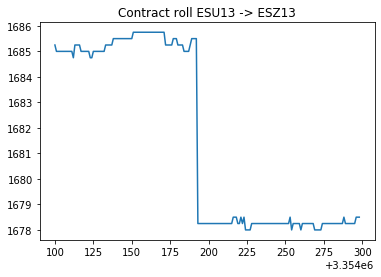

In [10]:
plt.plot(ES_Trades['Price'].iloc[3354100:3354299]) 
plt.title("Contract roll ESU13 -> ESZ13")

In [11]:
ES_Trades['Symbol'].drop_duplicates(keep='first').index

Int64Index([0, 3354193], dtype='int64')

To deal with this contract roll we use the book propose to **take a cumsum of all this rollover gaps and subtract it from the price series.** (The book implementation though is terrible) One other observation made in the book is that rolled price can become negative. So instead of dealing with rolled prices you can use a price series of a $1 investment.

Let's try to extract tick bars

In [46]:
tick_batch_size = 1000
tick_data_format = {
                '_Symbol':'Symbol', 
                '_Date':'Date',
                '_Time':'Time',
                '_Price':'Price', 
                '_Volume':'Volume', 
                }
extraction_columns = ['Price','Volume']
tick_data = ES_Trades

In [47]:
tick_data.index // tick_batch_size # https://stackoverflow.com/questions/20180324/bin-pandas-dataframe-by-every-x-rows

Int64Index([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            ...
            5454, 5454, 5454, 5454, 5454, 5454, 5454, 5454, 5454, 5454],
           dtype='int64', length=5454950)

In [48]:
tick_data = tick_data[extraction_columns]

In [53]:
O = tick_data.groupby(tick_data.index // tick_batch_size).first()
C = tick_data.groupby(tick_data.index // tick_batch_size).last()

In [20]:
H = tick_data.groupby(tick_data.index // tick_batch_size).Price.max()
L = tick_data.groupby(tick_data.index // tick_batch_size).Price.min()

In [33]:
assert ((len(O) - 1) * tick_batch_size < len(tick_data) < len(O) * tick_batch_size)

In [61]:
assert not O.empty

## 2. Count the number of bars produced by tick, volumne and dollar bars on a weekly basis. Plot a time series of that bar count. What bar type produces the most stable weekly count? Why?